# Multilevel Perceptron implementaton and walktrough

Welcome! In this notebook, I will be implementing a Fully connected neural network from scratch. The goal of this notebook is to portray my understanding of the underlying mechanics involved in training a neural network. The code is structured in a "bottom up" way, so after successfully implementing an element from scratch like a linear layer, I will be further substiuting it with the Pytorch equivelent.

So, lets not waste any more time and dive straight into it!!

Lets begin with some standard imports like matplotlib for the visualization of our data. For this walktrough, we will be working with the classic MNIST Dataset.

In [1]:
## necessary imports
import pickle,gzip,math,os,time,shutil,torch
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor
from fastcore.test import test_close


import torch.nn.functional as F
from torch import nn

In [2]:
## import data
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])
mpl.rcParams['image.cmap'] = 'gray'

Lets take a look at the first image from our training set!

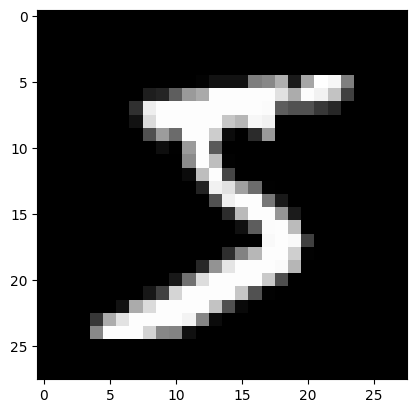

In [3]:
plt.imshow(x_train[0].view(28,28))

Lets take a look of the shapes of the data and the amount of classes.

In [4]:
n,m = x_train.shape
classes = y_train.max()+1
n, m, classes

(50000, 784, tensor(10))

# Starting with a very basic architecture - Foundation version

Lets start with initializing the weights and biases for a simple two layer architecture. The num_hidden variable represents the number of neurons (units) in the hidden layer of the neural network. I decided to move forward with 50 neurons.

These parameters (initialized as random value) will be updated in the training process when the network will be learning from the training data.


In [5]:
torch.manual_seed(42)
num_hidden = 50 

w1 = torch.randn(m,num_hidden)
b1 = torch.zeros(num_hidden)
w2 = torch.randn(num_hidden,1)
b2 = torch.zeros(1)

The Module class below is a simplified imitation of the 'nn.Module' class in PyTorch. The purpose of this class is that it represents a generic neural network module and provides a structure for building custom modules. The __call__ method is invoked when an instance of the class is called as a function. It later returns the output by calling the forward method with the appropriate arguments.

Both the forward and bwd methods are supposed to be implemented in the subclasses.



In [6]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out

    def forward(self): 
        raise Exception('not implemented')
        
    def backward(self): 
        self.bwd(self.out, *self.args)
        
    def bwd(self): 
        raise Exception('not implemented')

It is important to include non Linearity in our model. A simple way of achieving that is to implement the Rectified Linear Unit (ReLU). It works by allowing positive values to pass through unchanged, while setting all negative values to zero. Lets see how that would look like:

In [7]:
class Relu(Module):
    def forward(self, inp): 
        return inp.clamp_min(0.)
    def bwd(self, out, inp): # Implementing the bwd method to compute the gradients and updates the inp gradients 
        inp.g = (inp>0).float() * out.g

The code below defines a linear layer in a neural network. This class extends the previously defined Module class and includes methods for the forward pass and backward pass.
- the forward method computes the linear transformation by multiplying the input tensor by the weight matrix (inp @ self.w) and adding the bias vector (+ self.b).
- The bwd method is responsible for the backward pass, calculating gradients with respect to the input (inp), weight matrix (self.w), and bias vector (self.b).

In [8]:
# This is our Linear layer class, with initialized weights and biases and backward pass
class Linear(Module):
    def __init__(self, w, b): 
        self.w,self.b = w,b
    
    def forward(self, inp): 
        return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

Below is our first provisional loss function Mse (Mean Squared Error). This loss function is a starting point, and will be substituted with the more common Cross-Entropy Loss for classification tasks later in this notebook.

In [9]:
class Mse(Module):
    def forward (self, inp, targ): 
        return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): 
        inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]
     

*Constructing our model class*

In [10]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Linear(w1,b1), Relu(), Linear(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: 
            x = l(x)
        self.preds = x
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [11]:
model = Model(w1, b1, w2, b2)

In [12]:
loss = model(x_train, y_train)

In [13]:
model.backward()

In [14]:
model.preds

tensor([[-30.9709],
        [-99.3821],
        [  8.7239],
        ...,
        [-52.1168],
        [-46.2518],
        [ -4.3469]])

It works!!! But there is plenty of room for improvement...

Luckily, Pytorch has an automatic differentiation engine, so we dont have to calcualte the gradients ourselves any more. Lets see how that would look like. We can start with restructuring our linear layer class. 

In [15]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w = torch.randn(in_features, out_features).requires_grad_()
        self.b = torch.zeros(out_features).requires_grad_()
    def forward(self, inp): 
        return inp@self.w + self.b

In [16]:
class Model(nn.Module):
    def __init__(self, in_channels, hidden_layers, out_channels):
        super().__init__()
        self.layers = [Linear(in_channels,hidden_layers),
                       nn.ReLU(),
                       Linear(hidden_layers,out_channels)]
        
    def __call__(self, x, target):
        for l in self.layers: 
            x = l(x)
        return F.mse_loss(x, target.float()[:,None])

In [17]:
model = Model(m, num_hidden, 1)
loss = model(x_train, y_train.float())
loss.backward()    
loss

tensor(1549.3651, grad_fn=<MseLossBackward0>)

### Cross entropy loss


In order to have a fully functioning model, we have to substitute our previous MSE loss with a better one. Cross entropy loss is a commonly used loss function for classification tasks. To implement it, we first have to compute the logarithm of the softmax and furthermore take the negative of the loss likelyhood. This can be achieved in these two simpe steps:

In [18]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [19]:
def nll(input, target): 
    return -input[range(target.shape[0]), target].mean()

In [20]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh),
                       nn.ReLU(),
                       nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for layer in self.layers: x = layer(x)
        return x

In [21]:
model = Model(m, num_hidden, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [22]:
sm_pred = log_softmax(pred)

In [23]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3176, grad_fn=<NegBackward0>)

Great! Now that we have a better working loss function, we start thinking of an optimizer. 
The most common, and relatively simple to implement optimizer is Stochastic gradient descend.
The two main functionalities, we have to implement are: 
* A step function 
* A function to zero out the gradients after each pass. 

Lets see how that would look like in practice...

In [24]:
class Optimizer():
    def __init__(self, params, lr=0.5): 
        self.params = list(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params: 
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: 
            p.grad.data.zero_()

Some helper functions to help evaluate the model

In [25]:
def accuracy(out, yb): 
    return (out.argmax(dim=1)==yb).float().mean()

def report(loss, preds, yb): 
    print(f'Loss: {loss:.2f} | Accuracy: {accuracy(preds, yb):.2f}')

In [26]:
model = nn.Sequential(nn.Linear(m,num_hidden), nn.ReLU(), nn.Linear(num_hidden,10))

In [27]:
opt = Optimizer(model.parameters())
loss_func = F.cross_entropy

In [28]:
bs = 50 
epochs = 3 
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)


In [29]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

Loss: 0.17 | Accuracy: 0.94
Loss: 0.15 | Accuracy: 0.94
Loss: 0.12 | Accuracy: 0.94


Great! Looks like our optimizer is working correctly and our model is training.  

### The missing piece: Dataloaders and Dataset 
So far we have made solid progress, although oure code would be a lot cleaner, if we would implement a dataloader and dataset class
Lets to that!!!

#### Dataset class

In [30]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i],self.y[i]

In [31]:
train_data_set,valid_data_set = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [32]:
xb,yb = train_data_set[0:5]
xb.shape, yb

(torch.Size([5, 784]), tensor([5, 0, 4, 1, 9]))

In [33]:
model = nn.Sequential(nn.Linear(m,num_hidden), nn.ReLU(), nn.Linear(num_hidden,10))
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) 

In [34]:
for epoch in range(5):
    for i in range(0, n, bs):
        xb,yb = train_data_set[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    report(loss, preds, yb)
     

Loss: 0.35 | Accuracy: 0.92
Loss: 0.26 | Accuracy: 0.92
Loss: 0.21 | Accuracy: 0.92
Loss: 0.17 | Accuracy: 0.92
Loss: 0.14 | Accuracy: 0.94


#### Dataloader class

In [53]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): 
            yield self.ds[i:i+self.bs]

In [54]:
train_dl = DataLoader(train_data_set, bs)
valid_dl = DataLoader(valid_data_set, bs)

xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [55]:
model = nn.Sequential(nn.Linear(m,num_hidden), nn.ReLU(), nn.Linear(num_hidden,10))
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)     

In [56]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            # Do the forward pass
            preds = model(xb)
            # Calculate the loss
            loss = loss_func(preds, yb)
            # Zero the gradients
            optimizer.zero_grad()
            # Backward
            loss.backward()
            # step the optimizer
            optimizer.step()
            
        report(loss, preds, yb)

In [57]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)


Loss: 0.37 | Accuracy: 0.92
Loss: 0.28 | Accuracy: 0.92
Loss: 0.20 | Accuracy: 0.92


(tensor(0.1767, grad_fn=<NllLossBackward0>), tensor(0.9800))

Perfect! Our model is training correctly once again. This leaves us with one final step. 

### Validation set

The last step is to include our validation set. The validation set is very important because it tells us if we are overfitting on the training data. We can now substitute our manual dataloaders with PyTorches DataLoader class.

In [58]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_data_set, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_data_set, bs, shuffle=False, num_workers=2)

Great! Now it is time for the training loop with the addition of the validation set

In [80]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            # Calculate the loss
            loss = loss_func(model(xb), yb)
            
            # Zero out the gradients
            opt.zero_grad()
            # Do the backward pass
            loss.backward()
            # Step the optimizer
            opt.step()
        model.eval()
        with torch.no_grad():
            test_loss, test_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                test_loss += loss_func(pred,yb).item()*n
                test_acc  += accuracy (pred,yb).item()*n

        print(f"epoch: {epoch} | test loss: {test_loss/count} | Test accuracy: {test_acc/count}")
        
    return test_loss/count, test_acc/count

In [81]:
def get_data_loaders(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))
     

In [82]:

train_data_loader, valid_data_loader = get_data_loaders(train_data_set, valid_data_set, bs)
model = nn.Sequential(nn.Linear(m,num_hidden), nn.ReLU(), nn.Linear(num_hidden,10))
opt = torch.optim.SGD(model.parameters(), lr=0.05)   

%time loss,acc = fit(20, model, loss_func, opt, train_data_loader, valid_data_loader)
     


epoch: 0 | test loss: 0.3048352462425828 | Test accuracy: 0.915900000333786
epoch: 1 | test loss: 0.25316496428102253 | Test accuracy: 0.9290000027418137
epoch: 2 | test loss: 0.21493432955816388 | Test accuracy: 0.9406000018119812
epoch: 3 | test loss: 0.1852528131380677 | Test accuracy: 0.9477000004053115
epoch: 4 | test loss: 0.1661680996976793 | Test accuracy: 0.9544000053405761
epoch: 5 | test loss: 0.15068742735311388 | Test accuracy: 0.9596000051498413
epoch: 6 | test loss: 0.14419448643922805 | Test accuracy: 0.9585000038146972
epoch: 7 | test loss: 0.13473034169524908 | Test accuracy: 0.9620000052452088
epoch: 8 | test loss: 0.1290793955512345 | Test accuracy: 0.9632000041007995
epoch: 9 | test loss: 0.11868104227818549 | Test accuracy: 0.9660000044107437
epoch: 10 | test loss: 0.1194089087517932 | Test accuracy: 0.9661000055074692
epoch: 11 | test loss: 0.11515257748775184 | Test accuracy: 0.9650000089406967
epoch: 12 | test loss: 0.10903757377061993 | Test accuracy: 0.967600

### Conclusion

This project has provided a comprehensive exploration into the implementation of a neural network from scratch. By diving into the foundational components such as linear layers, activation functions, and loss functions, I have gained a deep understanding of the inner mechanics in a neural network.

